In [1]:
merge_path = r"C:\Users\Lion\NFHS\2019-2021\Individual Recode-IAIR7EDT\nfhs5_women_biomarkers.parquet"  
ir_path     = r"C:\Users\Lion\NFHS\2019-2021\Individual Recode-IAIR7EDT\nfhs5_ir_thin_clean.parquet"   


In [2]:
import pandas as pd

ir = pd.read_parquet(r"C:\Users\Lion\NFHS\2019-2021\Individual Recode-IAIR7EDT\nfhs5_ir_thin_clean.parquet")
cols = set(ir.columns)
print("Caste columns present?:", {"s116": "s116" in cols, "v131": "v131" in cols})
if "s116" in cols:
    print("\ns116 value counts:")
    print(ir["s116"].value_counts(dropna=False).sort_index())
if "v131" in cols:
    print("\nv131 value counts:")
    print(ir["v131"].value_counts(dropna=False).sort_index())


Caste columns present?: {'s116': False, 'v131': True}

v131 value counts:
v131
991    583167
992    101914
993     34661
998      4373
Name: count, dtype: int64


In [3]:
import pandas as pd

merge_path = r"C:\Users\Lion\NFHS\2019-2021\Individual Recode-IAIR7EDT\nfhs5_women_biomarkers.parquet"
ir_path    = r"C:\Users\Lion\NFHS\2019-2021\Individual Recode-IAIR7EDT\nfhs5_ir_thin_clean.parquet"

m  = pd.read_parquet(merge_path)
ir = pd.read_parquet(ir_path)

# not sure about caste yet, please ignore
caste_col = "s116" if "s116" in ir.columns else ("v131" if "v131" in ir.columns else None)
if caste_col is None:
    raise KeyError("Neither s116 nor v131 exists in the IR file; cannot add caste.")

g
if caste_col not in m.columns:
  
    for k in ["v001","v002","v003"]:
        if k in m.columns:
            m[k]  = pd.to_numeric(m[k],  errors="coerce").astype("Int64")
        if k in ir.columns:
            ir[k] = pd.to_numeric(ir[k], errors="coerce").astype("Int64")
    # bring just the join keys + caste
    keep = ["v001","v002","v003", caste_col]
    ir_slim = ir[keep].drop_duplicates(subset=["v001","v002","v003"])
    m = m.merge(ir_slim, on=["v001","v002","v003"], how="left")
    m.to_parquet(merge_path, index=False)
    print(f"Added caste column '{caste_col}' and saved back to:\n  {merge_path}")
else:
    print(f"Caste column '{caste_col}' already present in merged file.")


Caste column 'v131' already present in merged file.


In [4]:
import pandas as pd
m = pd.read_parquet(merge_path)

print("Columns present? ", all(c in m.columns for c in ["v106","v190", "s116"]) or "v131" in m.columns)

print("\nV106 (education):")
print(m["v106"].value_counts(dropna=False).sort_index())

print("\nV190 (wealth):")
print(m["v190"].value_counts(dropna=False).sort_index())

e
caste_col = "s116" if "s116" in m.columns else ("v131" if "v131" in m.columns else None)
print(f"\nCaste ({caste_col}):")
print(m[caste_col].value_counts(dropna=False).sort_index())


Columns present?  True

V106 (education):
v106
0    167304
1     84983
2    370012
3    101816
Name: count, dtype: int64

V190 (wealth):
v190
1    149844
2    160340
3    151505
4    139607
5    122819
Name: count, dtype: int64

Caste (v131):
v131
991    583167
992    101914
993     34661
998      4373
Name: count, dtype: int64


In [6]:
import os, yaml


print("CWD:", os.getcwd())

# relocating thresholds.yml 
if not os.path.exists("thresholds.yml"):
    yaml_text = """threshold_sets:
      - name: base
        bmi_abn_ge: 23.0
        bp_sbp_ge: 140
        bp_dbp_ge: 90
        glucose_abn_ge: 200
        waist_f_ge_cm: 80
        hb_f_lt_gdl: 12.0
      - name: liberal_hgb
        bmi_abn_ge: 23.0
        bp_sbp_ge: 140
        bp_dbp_ge: 90
        glucose_abn_ge: 200
        waist_f_ge_cm: 80
        hb_f_lt_gdl: 11.5
      - name: tight_bp
        bmi_abn_ge: 23.0
        bp_sbp_ge: 130
        bp_dbp_ge: 80
        glucose_abn_ge: 200
        waist_f_ge_cm: 80
        hb_f_lt_gdl: 12.0
      - name: tight_bp__liberal_hgb
        bmi_abn_ge: 23.0
        bp_sbp_ge: 130
        bp_dbp_ge: 80
        glucose_abn_ge: 200
        waist_f_ge_cm: 80
        hb_f_lt_gdl: 11.5
    """
    with open("thresholds.yml","w",encoding="utf-8") as f:
        f.write(yaml_text)
    print("Wrote thresholds.yml")
else:
    print("thresholds.yml already present")


CWD: C:\Users\Lion\NFHS\CODES
Wrote thresholds.yml


In [7]:
with open("thresholds.yml","r",encoding="utf-8") as f:
    base = next(s for s in yaml.safe_load(f)["threshold_sets"] if s["name"]=="base")


In [8]:
import pandas as pd, yaml
import numpy as np

# paths and just loading data and weights
merge_path = r"C:\Users\Lion\NFHS\2019-2021\Individual Recode-IAIR7EDT\nfhs5_women_biomarkers.parquet"

m = pd.read_parquet(merge_path).copy()
w = pd.to_numeric(m["v005"], errors="coerce")/1_000_000

# base thresholds (same as Code_6)
with open("thresholds.yml","r",encoding="utf-8") as f:
    base = next(s for s in yaml.safe_load(f)["threshold_sets"] if s["name"]=="base")

# build flags (True = abnormal)
m["BMI_abn"]   = (m["bmi"] >= base["bmi_abn_ge"])
m["BP_abn"]    = ((m["sbp_clean"] >= base["bp_sbp_ge"]) | (m["dbp_clean"] >= base["bp_dbp_ge"]))
m["GLU_abn"]   = (m["glucose_mgdl"] >= base["glucose_abn_ge"])
m["WAIST_abn"] = (m["waist_cm"] >= base["waist_f_ge_cm"])
m["HGB_abn"]   = (m["hb_gdl"] < base["hb_f_lt_gdl"])

# mask: who has a value for each metric
den_bmi   = m["bmi"].notna()
den_bp    = m["sbp_clean"].notna() | m["dbp_clean"].notna()
den_glu   = m["glucose_mgdl"].notna()
den_waist = m["waist_cm"].notna()
den_hb    = m["hb_gdl"].notna()

# all five present
present_all5 = m[["bmi","sbp_clean","dbp_clean","glucose_mgdl","waist_cm","hb_gdl"]].notna().all(axis=1)

# fully healthy (strict): all five present AND none abnormal
none_abn = ~(m["BMI_abn"] | m["BP_abn"] | m["GLU_abn"] | m["WAIST_abn"] | m["HGB_abn"])
fully_healthy = present_all5 & none_abn


In [9]:
# Education v106: 0 No edu, 1 Primary, 2 Secondary, 3 Higher.... just labeling
edu_map = {0:"No education", 1:"Primary", 2:"Secondary", 3:"Higher"}
m["edu_cat"] = m["v106"].map(edu_map).fillna("Unknown")

# Wealth v190: 1 Poorest ... 5 Richest 
wealth_map = {1:"Poorest", 2:"Poorer", 3:"Middle", 4:"Richer", 5:"Richest"}
m["wealth_cat"] = m["v190"].map(wealth_map).fillna("Unknown")

# ignore caste for now
caste_map_v131 = {1:"Scheduled caste", 2:"Scheduled tribe", 3:"OBC", 4:"None of them"}
m["caste_cat"] = m["v131"].map(caste_map_v131).fillna("Unknown")


In [10]:
def wshare(flag_bool, denom_mask):
    num = (flag_bool.astype(int) * w).where(denom_mask, 0).sum()
    den = w.where(denom_mask, 0).sum()
    return float(num/den*100) if den>0 else np.nan

def table_by_group(group_col, group_order=None):
    """Return one tidy table per metric with 3 columns:
       - group_abnormal_% (weighted, denom = has data for that metric)
       - control_all_women_% (same denom as metric)
       - control_healthy_% (weighted among fully healthy & all five present)"""
    denoms = {
        "BMI":   den_bmi,
        "BP":    den_bp,
        "GLU":   den_glu,
        "WAIST": den_waist,
        "HGB":   den_hb,
    }
    flags = {
        "BMI":   m["BMI_abn"],
        "BP":    m["BP_abn"],
        "GLU":   m["GLU_abn"],
        "WAIST": m["WAIST_abn"],
        "HGB":   m["HGB_abn"],
    }

    # build rows
    cats = m[group_col].astype("string")
    if group_order is None:
        group_order = list(cats.dropna().unique())

    out = []
    for g in group_order:
        sel = (cats == g)
        row = {"group": g}
        for metric in ["BMI","BP","GLU","WAIST","HGB"]:
            den = denoms[metric]
            row[f"{metric}_abn_w%"] = round(wshare(flags[metric] & sel, den & sel), 2)
            # controls
            row[f"{metric}_control_all_women_w%"] = round(wshare(flags[metric], den), 2)
            row[f"{metric}_control_healthy_w%"]   = round(
                (fully_healthy.astype(int) * w).sum() / w.where(present_all5,0).sum() * 100, 2
            )
        out.append(row)

    return pd.DataFrame(out)
#Helper to compute weighted% abnormal for a group. 

In [17]:
import yaml
import numpy as np
import pandas as pd

#Producing the three SES tables and saving them

# Load base thresholds (same as in Code_6)
with open("thresholds.yml","r",encoding="utf-8") as f:
    base = next(s for s in yaml.safe_load(f)["threshold_sets"] if s["name"]=="base")

def group_stats(m, w, group_col, base):
    """Return a 3-column panel (metric, all-women control, healthy control) per group."""
    # denominators
    den_bmi   = m["bmi"].notna()
    den_bp    = m["sbp_clean"].notna() | m["dbp_clean"].notna()
    den_glu   = m["glucose_mgdl"].notna()
    den_waist = m["waist_cm"].notna()
    den_hb    = m["hb_gdl"].notna()
    present_all5 = m[["bmi","sbp_clean","dbp_clean","glucose_mgdl","waist_cm","hb_gdl"]].notna().all(axis=1)

    # abnormal flags (base)
    BMI_abn   = (m["bmi"]          >= base["bmi_abn_ge"])
    BP_abn    = ((m["sbp_clean"]   >= base["bp_sbp_ge"]) | (m["dbp_clean"] >= base["bp_dbp_ge"]))
    GLU_abn   = (m["glucose_mgdl"] >= base["glucose_abn_ge"])
    WAIST_abn = (m["waist_cm"]     >= base["waist_f_ge_cm"])
    HGB_abn   = (m["hb_gdl"]       <  base["hb_f_lt_gdl"])
    healthy   = present_all5 & ~(BMI_abn | BP_abn | GLU_abn | WAIST_abn | HGB_abn)

    def wshare(flag_bool, denom_mask):
        num = (flag_bool.astype(int) * w).where(denom_mask, 0).sum()
        den = w.where(denom_mask, 0).sum()
        return float(num/den*100) if den > 0 else np.nan

    rows = []
    for g, _ in m.groupby(group_col, dropna=False):
        idx = (m[group_col] == g)
        label = "Unknown" if pd.isna(g) else str(g)
        rows.append({
            "group": label,

            "BMI_abn_w%":                   round(wshare(BMI_abn & idx,   den_bmi   & idx), 2),
            "BMI_control_all_women_w%":     round(wshare(BMI_abn,          den_bmi),        2),
            "BMI_control_healthy_w%":       round(wshare(~BMI_abn & healthy, present_all5), 2),

            "BP_abn_w%":                    round(wshare(BP_abn & idx,    den_bp    & idx), 2),
            "BP_control_all_women_w%":      round(wshare(BP_abn,           den_bp),         2),
            "BP_control_healthy_w%":        round(wshare(~BP_abn & healthy, present_all5),  2),

            "GLU_abn_w%":                   round(wshare(GLU_abn & idx,   den_glu   & idx), 2),
            "GLU_control_all_women_w%":     round(wshare(GLU_abn,          den_glu),        2),
            "GLU_control_healthy_w%":       round(wshare(~GLU_abn & healthy, present_all5), 2),

            "WAIST_abn_w%":                 round(wshare(WAIST_abn & idx, den_waist & idx), 2),
            "WAIST_control_all_women_w%":   round(wshare(WAIST_abn,        den_waist),      2),
            "WAIST_control_healthy_w%":     round(wshare(~WAIST_abn & healthy, present_all5), 2),

            "HGB_abn_w%":                   round(wshare(HGB_abn & idx,   den_hb    & idx), 2),
            "HGB_control_all_women_w%":     round(wshare(HGB_abn,          den_hb),         2),
            "HGB_control_healthy_w%":       round(wshare(~HGB_abn & healthy, present_all5), 2),
        })
    return pd.DataFrame(rows)


In [21]:

caste_col = "v131"  #should be s116 but we will focus on that later

caste_map = {
    991: "Scheduled caste",
    992: "Scheduled tribe",
    993: "OBC",
    998: "None of them",
    999: "Don't know",
}
m["caste_lbl"] = pd.to_numeric(m[caste_col], errors="coerce").map(caste_map).fillna("Unknown")

tbl_caste = group_stats(m, w, group_col="caste_lbl", base=base)
print(tbl_caste)



             group  BMI_abn_w%  BMI_control_all_women_w%  \
0     None of them       39.57                     37.95   
1              OBC       39.70                     37.95   
2  Scheduled caste       38.70                     37.95   
3  Scheduled tribe       25.31                     37.95   

   BMI_control_healthy_w%  BP_abn_w%  BP_control_all_women_w%  \
0                   18.25       7.76                     9.88   
1                   18.25      10.28                     9.88   
2                   18.25       9.84                     9.88   
3                   18.25      10.46                     9.88   

   BP_control_healthy_w%  GLU_abn_w%  GLU_control_all_women_w%  \
0                  18.25        1.42                      1.42   
1                  18.25        1.90                      1.42   
2                  18.25        1.44                      1.42   
3                  18.25        0.79                      1.42   

   GLU_control_healthy_w%  WAIST_abn_w%  W

In [22]:
# categorising
edu_order    = ["No education","Primary","Secondary","Higher","Unknown"]
wealth_order = ["Poorest","Poorer","Middle","Richer","Richest","Unknown"]
caste_order  = ["Scheduled caste","Scheduled tribe","OBC","None of them","Unknown"]

tbl_edu    = table_by_group("edu_cat",    edu_order)
tbl_wealth = table_by_group("wealth_cat", wealth_order)
tbl_caste  = table_by_group("caste_cat",  caste_order)

tbl_edu.to_csv("section2_education_vs_abnormality.csv", index=False)
tbl_wealth.to_csv("section2_wealth_vs_abnormality.csv", index=False)
tbl_caste.to_csv("section2_caste_vs_abnormality.csv", index=False)

tbl_edu, tbl_wealth, tbl_caste  # quick peek


(          group  BMI_abn_w%  BMI_control_all_women_w%  BMI_control_healthy_w%  \
 0  No education       36.13                     37.95                   18.25   
 1       Primary       40.59                     37.95                   18.25   
 2     Secondary       36.35                     37.95                   18.25   
 3        Higher       43.87                     37.95                   18.25   
 4       Unknown         NaN                     37.95                   18.25   
 
    BP_abn_w%  BP_control_all_women_w%  BP_control_healthy_w%  GLU_abn_w%  \
 0      14.42                     9.88                  18.25        1.73   
 1      12.82                     9.88                  18.25        1.86   
 2       8.16                     9.88                  18.25        1.33   
 3       6.51                     9.88                  18.25        0.90   
 4        NaN                     9.88                  18.25         NaN   
 
    GLU_control_all_women_w%  GLU_control_

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


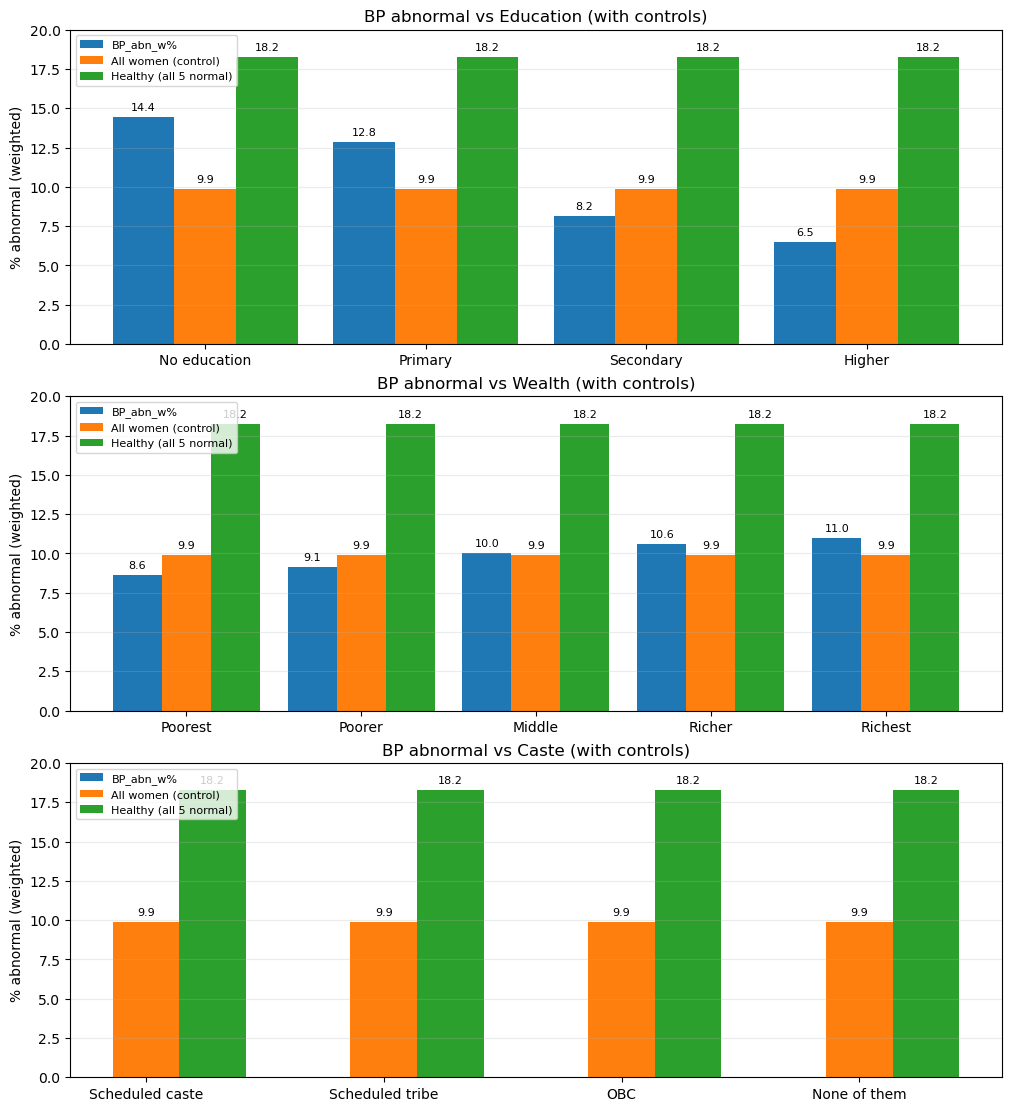

In [24]:
import matplotlib.pyplot as plt

def nice_bar(ax, df, metric, title, ylim=(0,20), drop_unknown=True):
    """
    df: table with columns [group, <metric>_abn_w%, <metric>_control_all_women_w%, <metric>_control_healthy_w%]
    metric: 'BP', 'BMI', 'WAIST', 'HGB', 'GLU'
    """
    g = df.copy()
    if drop_unknown:
        g = g[g["group"].str.lower()!="unknown"]

    y_cols = [f"{metric}_abn_w%", f"{metric}_control_all_women_w%", f"{metric}_control_healthy_w%"]
    g = g[["group"] + y_cols]

    x = range(len(g))
    width = 0.28

    ax.bar([i - width for i in x], g[y_cols[0]].values, width, label=f"{metric}_abn_w%")
    ax.bar(x,                           g[y_cols[1]].values, width, label="All women (control)")
    ax.bar([i + width for i in x], g[y_cols[2]].values, width, label="Healthy (all 5 normal)")

    ax.set_title(title)
    ax.set_ylabel("% abnormal (weighted)")
    ax.set_xticks(list(x))
    ax.set_xticklabels(g["group"].tolist(), rotation=0)
    ax.set_ylim(*ylim)
    ax.grid(axis="y", alpha=0.25)

    # value labels on bars
    for i in x:
        for j, off in enumerate([-width, 0, +width]):
            val = g.iloc[i, 1+j]
            ax.text(i+off, val+0.3, f"{val:.1f}", ha="center", va="bottom", fontsize=8)

    ax.legend(fontsize=8, loc="upper left")

# EXAMPLE: BP for the three factors
fig, axes = plt.subplots(3, 1, figsize=(10, 11), constrained_layout=True)

nice_bar(axes[0], tbl_edu,    "BP", "BP abnormal vs Education (with controls)",  ylim=(0,20))
nice_bar(axes[1], tbl_wealth, "BP", "BP abnormal vs Wealth (with controls)",     ylim=(0,20))
nice_bar(axes[2], tbl_caste,  "BP", "BP abnormal vs Caste (with controls)",      ylim=(0,20))

plt.show()
# plt.savefig("figs/section2_bp_vs_edu_wealth_caste.png", dpi=200)

In [25]:
import os, matplotlib.pyplot as plt
os.makedirs("figs", exist_ok=True)

def nice_bar(ax, df, metric, title, ylim=(0,20), drop_unknown=True):
    g = df.copy()
    if drop_unknown:
        g = g[g["group"].str.lower()!="unknown"]

    y_cols = [f"{metric}_abn_w%", f"{metric}_control_all_women_w%", f"{metric}_control_healthy_w%"]
    g = g[["group"] + y_cols]

    x = range(len(g))
    width = 0.28

    ax.bar([i - width for i in x], g[y_cols[0]].values, width, label=f"{metric}_abn_w%")
    ax.bar(x,                           g[y_cols[1]].values, width, label="All women (control)")
    ax.bar([i + width for i in x], g[y_cols[2]].values, width, label="Healthy (all 5 normal)")

    ax.set_title(title)
    ax.set_ylabel("% abnormal (weighted)")
    ax.set_xticks(list(x))
    ax.set_xticklabels(g["group"].tolist(), rotation=0)
    ax.set_ylim(*ylim)
    ax.grid(axis="y", alpha=0.25)

    # value labels on bars
    for i in x:
        for off, col in zip([-width, 0, +width], y_cols):
            val = g.iloc[i][col]
            ax.text(i+off, val+0.3, f"{val:.1f}", ha="center", va="bottom", fontsize=8)

    ax.legend(fontsize=8, loc="upper left")


In [26]:
ylims = {
    "BP":    (0, 20),
    "GLU":   (0, 4),
    "BMI":   (0, 60),
    "WAIST": (0, 60),
    "HGB":   (40, 70),
}
metrics = ["BP","GLU","BMI","WAIST","HGB"]


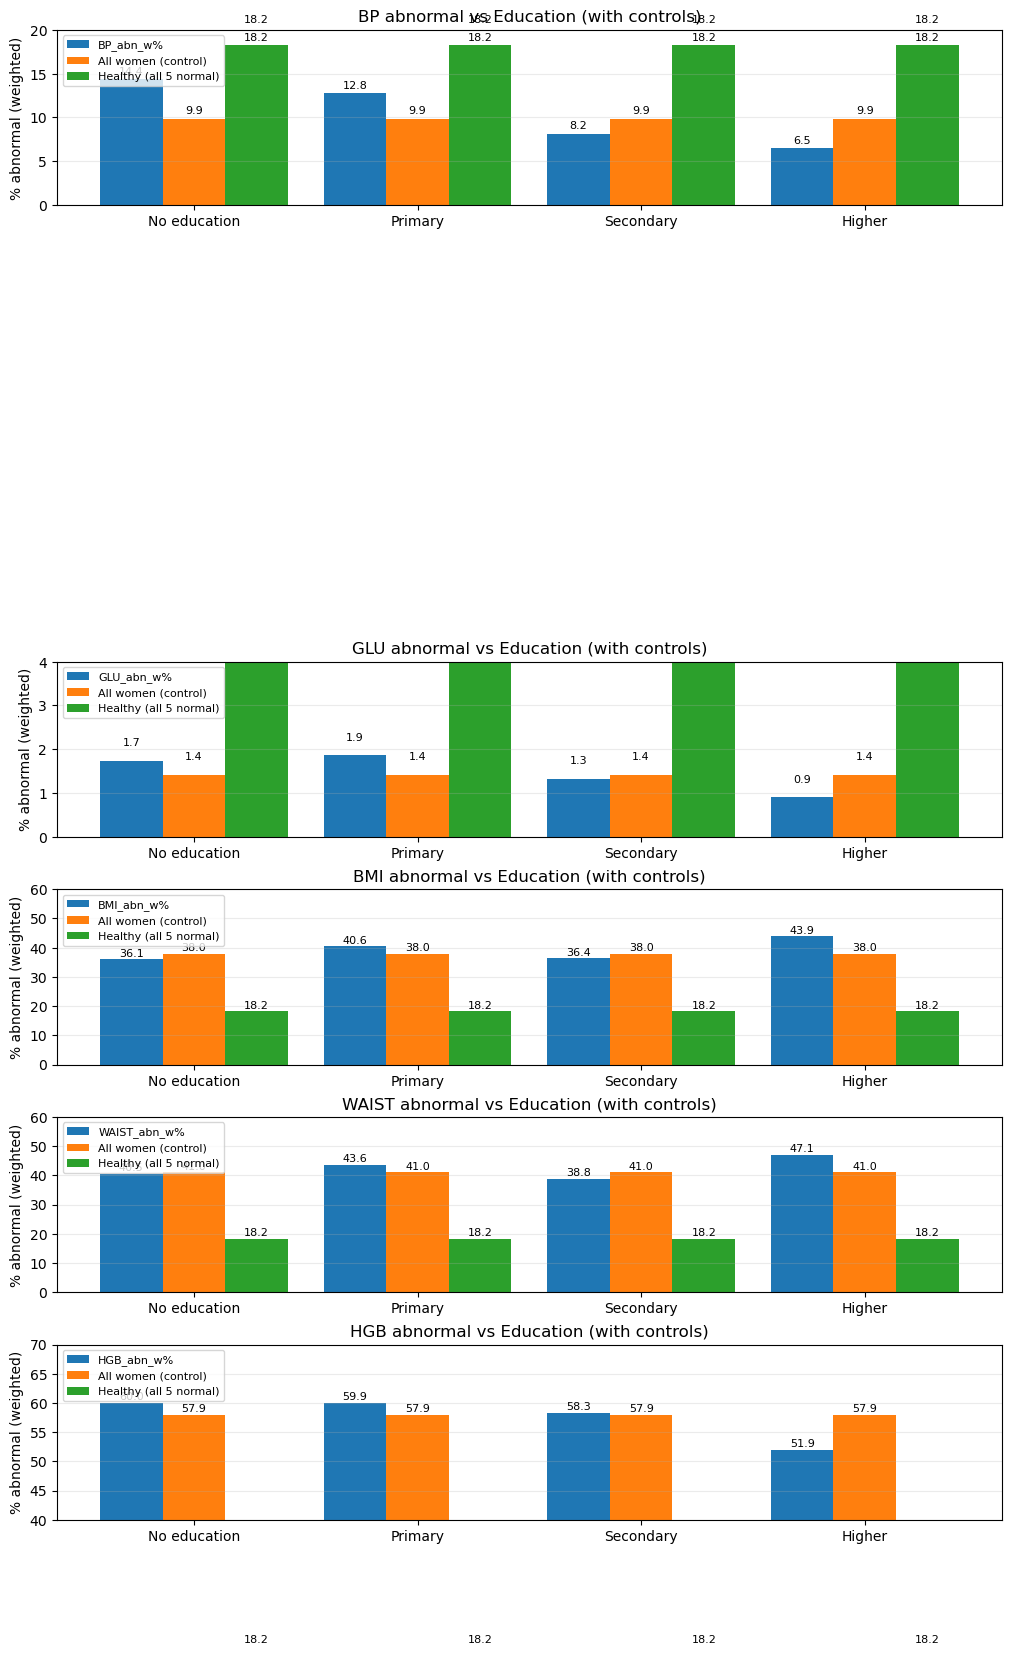

saved: figs/education_all_metrics.png


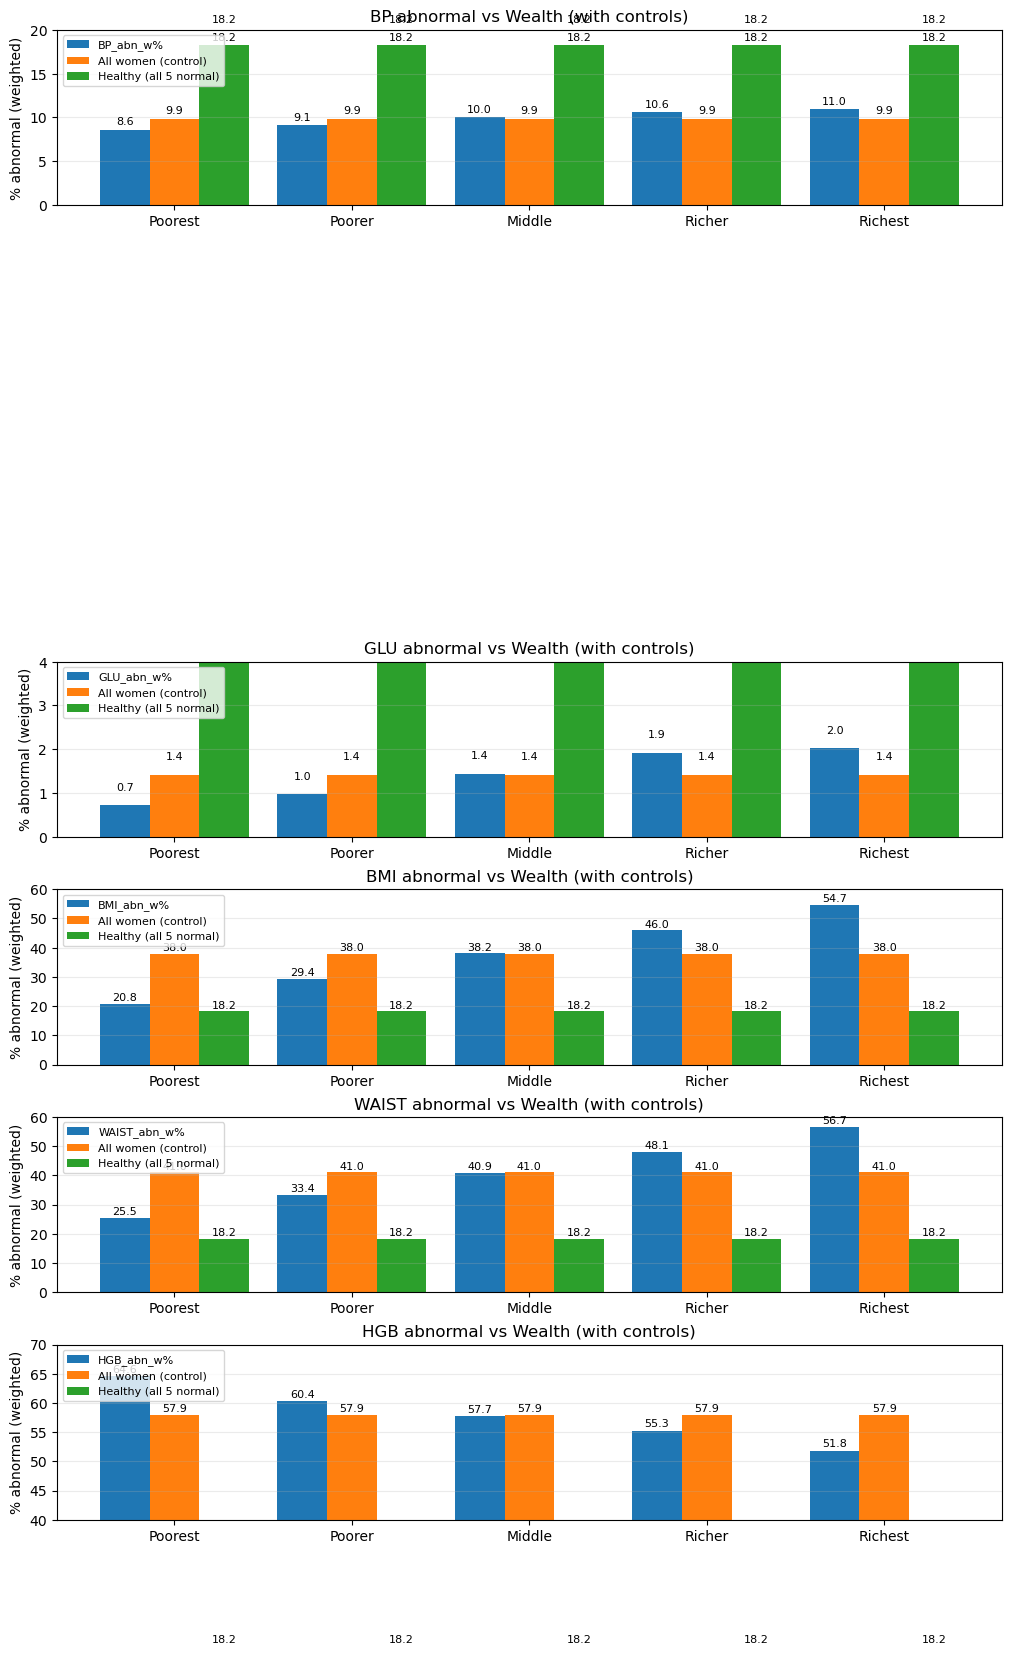

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


saved: figs/wealth_all_metrics.png


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and pos

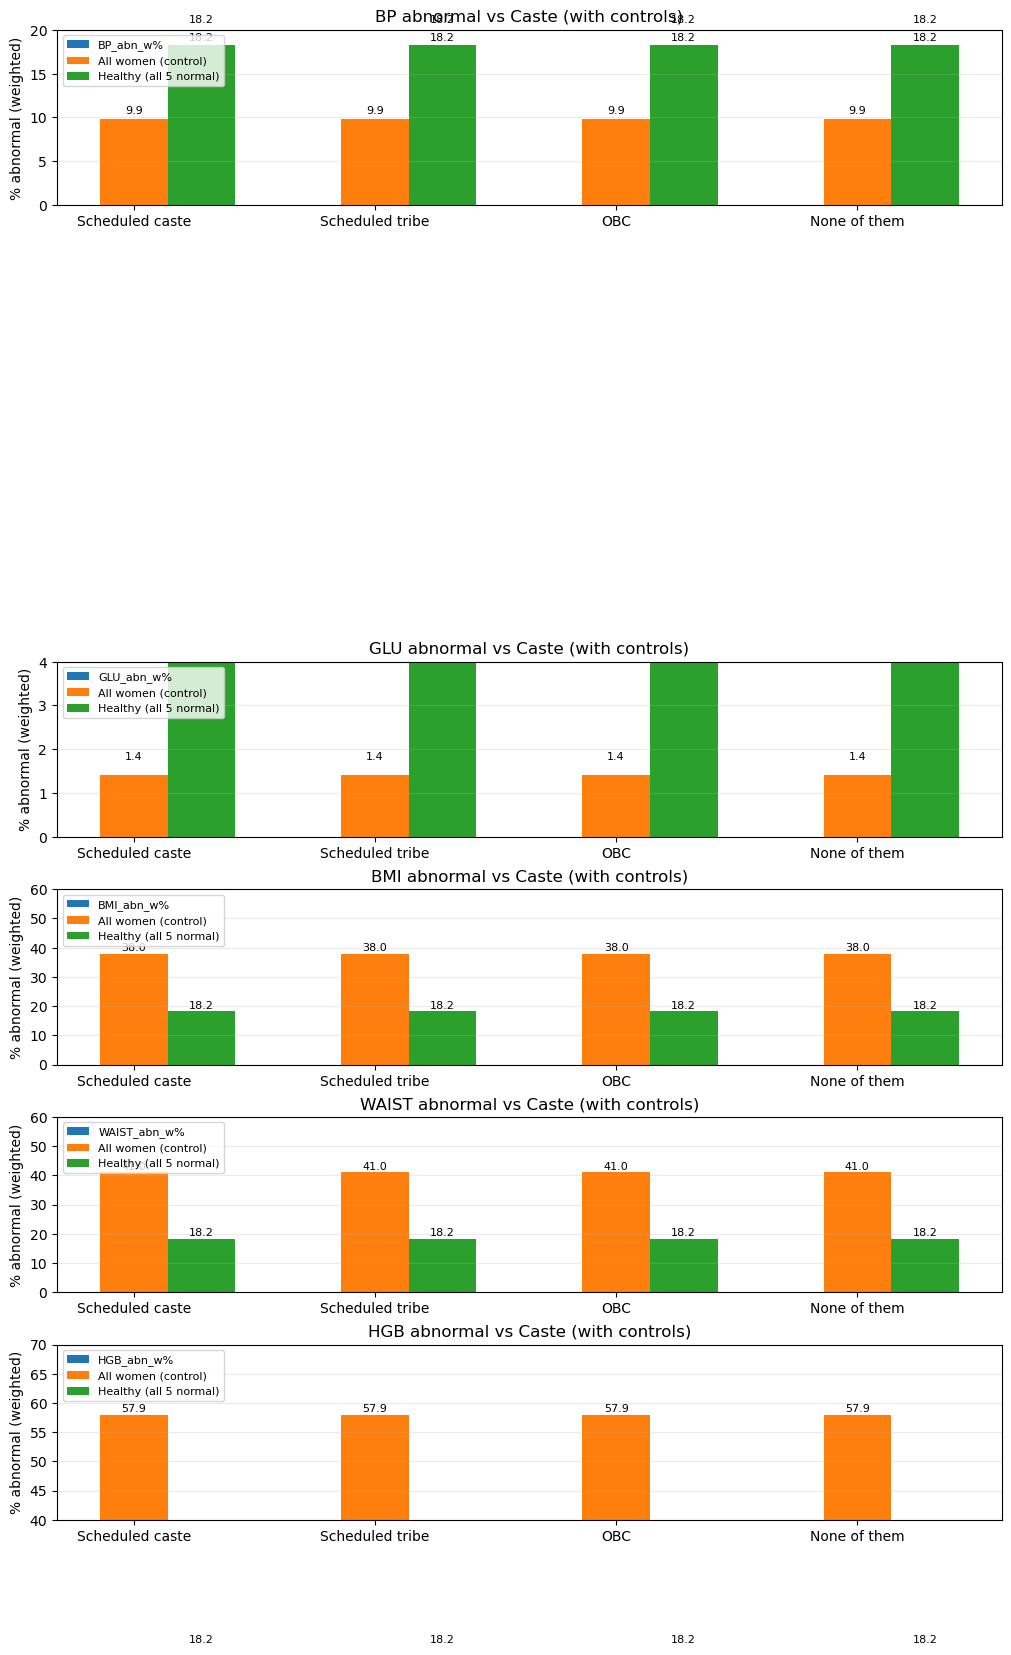

saved: figs/caste_all_metrics.png


In [27]:
#now show it all for all metrics (again, ignore caste for now) 

def plot_all_for_factor(tbl, factor_name, drop_unknown=True):
    fig, axes = plt.subplots(5, 1, figsize=(10, 16), constrained_layout=True)
    for ax, m in zip(axes, metrics):
        nice_bar(ax, tbl, m, f"{m} abnormal vs {factor_name} (with controls)",
                 ylim=ylims[m], drop_unknown=drop_unknown)
    out = f"figs/{factor_name.lower()}_all_metrics.png"
    plt.savefig(out, dpi=200)
    plt.show()
    print("saved:", out)

plot_all_for_factor(tbl_edu,    "Education")
plot_all_for_factor(tbl_wealth, "Wealth")
plot_all_for_factor(tbl_caste,  "Caste")
